In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import nasdaqdatalink
import os
from dotenv import load_dotenv
load_dotenv()
API_KEY= os.getenv('API_KEY')
nasdaqdatalink.ApiConfig.api_key = API_KEY

In [5]:

# Define the asset universe
tickers = {
    # US Equities
    'SPY': 'QUOTEMEDIA/PRICES',  # S&P 500 ETF
    'QQQ': 'QUOTEMEDIA/PRICES',  # Nasdaq 100 ETF
    'IWM': 'QUOTEMEDIA/PRICES',  # Russell 2000 ETF (Small Cap)
    # International Equities
    'EFA': 'QUOTEMEDIA/PRICES',  # MSCI EAFE ETF (Developed Markets ex-US/Canada)
    'EEM': 'QUOTEMEDIA/PRICES',  # MSCI Emerging Markets ETF
    # Fixed Income
    'AGG': 'QUOTEMEDIA/PRICES',  # US Aggregate Bond ETF
    'TLT': 'QUOTEMEDIA/PRICES',  # US 20+ Year Treasury Bond ETF
    # Commodities
    'GLD': 'QUOTEMEDIA/PRICES',  # Gold ETF
    'USO': 'QUOTEMEDIA/PRICES',  # Oil ETF
    # Real Estate
    'VNQ': 'QUOTEMEDIA/PRICES',   # US Real Estate ETF
    # Adding a couple more for diversity
    'GSG': 'QUOTEMEDIA/PRICES', # Broad Commodities ETF
    'HYG': 'QUOTEMEDIA/PRICES'  # High Yield Corporate Bond ETF
}

start_date = '2010-01-01'


In [6]:
# Fetch data for each ticker
all_data = {}
for ticker, table in tickers.items():
    print(f"Fetching data for {ticker} from {table}...")
    try:
        # Fetch data from the specified start_date
        data = nasdaqdatalink.get_table(
            table, 
            ticker=ticker, 
            qopts={'columns': ['date', 'adj_close']},
            date={'gte': start_date},
            paginate=True
        )
        if not data.empty:
            data = data.set_index('date')
            all_data[ticker] = data['adj_close']
        else:
            print(f"No data found for {ticker}")
    except Exception as e:
        print(f"Could not retrieve data for {ticker}: {e}")

# Combine into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    price_df = price_df.sort_index() # Ensure dates are in ascending order
    print("\nSuccessfully fetched and combined data for all available tickers.")
    print(f"Price data from {price_df.index.min()} to {price_df.index.max()}")
    # Display the head and tail to check the date range and data
    print("\nHead of combined price data:")
    print(price_df.head())
    print("\nTail of combined price data:")
    print(price_df.tail())
else:
    print("No data was fetched. Please check ticker symbols and API key.")

Fetching data for SPY from QUOTEMEDIA/PRICES...
Fetching data for QQQ from QUOTEMEDIA/PRICES...
Fetching data for IWM from QUOTEMEDIA/PRICES...
Fetching data for EFA from QUOTEMEDIA/PRICES...
Fetching data for EEM from QUOTEMEDIA/PRICES...
Fetching data for AGG from QUOTEMEDIA/PRICES...
Fetching data for TLT from QUOTEMEDIA/PRICES...
Fetching data for GLD from QUOTEMEDIA/PRICES...
Fetching data for USO from QUOTEMEDIA/PRICES...
Fetching data for VNQ from QUOTEMEDIA/PRICES...
Fetching data for GSG from QUOTEMEDIA/PRICES...
Fetching data for HYG from QUOTEMEDIA/PRICES...

Successfully fetched and combined data for all available tickers.
Price data from 2010-01-04 00:00:00 to 2025-05-09 00:00:00

Head of combined price data:
                  SPY        QQQ        IWM        EFA        EEM        AGG  \
date                                                                           
2010-01-04  85.431304  40.661575  52.874052  36.997067  32.075579  70.784725   
2010-01-05  85.657449  40.66

In [7]:
# Resample to monthly frequency (end of month) and calculate returns
if 'price_df' in locals() and not price_df.empty:
    # Forward fill to handle missing values before resampling, then backfill
    price_df_filled = price_df.ffill().bfill()
    
    # Resample to monthly frequency, taking the last available price in the month
    monthly_prices = price_df_filled.resample('M').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Drop the first row of NaNs resulting from pct_change()
    monthly_returns = monthly_returns.dropna(how='all', axis=0)
    
    print("\nMonthly returns calculated.")
    print("\nHead of monthly returns data:")
    print(monthly_returns.head())
    print("\nTail of monthly returns data:")
    print(monthly_returns.tail())
    print("\nShape of monthly returns data:", monthly_returns.shape)
else:
    print("price_df is not available or empty. Cannot calculate monthly returns.")


Monthly returns calculated.

Head of monthly returns data:
                 SPY       QQQ       IWM       EFA       EEM       AGG  \
date                                                                     
2010-02-28  0.031195  0.046039  0.044751  0.002668  0.017764  0.001989   
2010-03-31  0.060902  0.077127  0.082375  0.063854  0.081173 -0.000071   
2010-04-30  0.015470  0.022373  0.056746 -0.028046 -0.001721  0.009734   
2010-05-31 -0.079455 -0.073877 -0.075366 -0.111928 -0.093936  0.010825   
2010-06-30 -0.051746 -0.061598 -0.077509 -0.020739 -0.014013  0.017678   

                 TLT       GLD       USO       VNQ       GSG       HYG  
date                                                                    
2010-02-28 -0.003392  0.032748  0.089226  0.055832  0.059166  0.018696  
2010-03-31 -0.024297 -0.004386  0.037867  0.101848  0.006135  0.021333  
2010-04-30  0.037168  0.058834  0.025813  0.071502  0.031451  0.019263  
2010-05-31  0.051089  0.030522 -0.176409 -0.053346 -0.13

/var/folders/b_/87z_y1k156v1lhn4cngf1jgr0000gn/T/ipykernel_63095/1088191404.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = price_df_filled.resample('M').last()


<Axes: xlabel='date'>

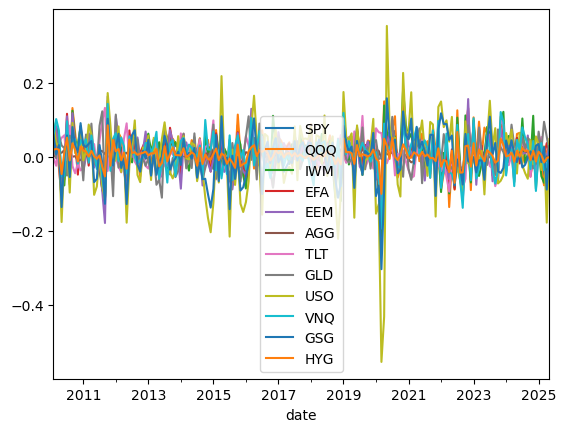

In [8]:
monthly_returns.plot()